Using Martynov Andrey's autokeras notebook for reference: https://www.kaggle.com/code/martynovandrey/autokeras-classifier
Thanks to him for helping me learn something new!

In [1]:
# !pip install autokeras

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import scipy
from scipy import sparse
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import time
import autokeras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2023-02-11 16:36:16.744394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 16:36:16.883128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-11 16:36:16.883171: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-11 16:36:17.911788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

/kaggle/input/berta-train-df/Train DF with Berta.csv
/kaggle/input/sentiment-analysis-company-reviews/sample_submission.csv
/kaggle/input/sentiment-analysis-company-reviews/train.csv
/kaggle/input/sentiment-analysis-company-reviews/test.csv


In [3]:
# # Code to detect GPUs
# tf.test.gpu_device_name()
# # Set strategy to use GPUs
# strategy = tf.distribute.MirroredStrategy()

# Code to detect TPUs
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# print('Running on TPU ', tpu.master())

In [4]:
train_df = pd.read_csv('/kaggle/input/sentiment-analysis-company-reviews/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-company-reviews/test.csv', index_col=[0])

Starting with Autokeras implementation, which gave the best outputs

In [11]:
Xtrain = np.array(train_df.Review)
ytrain = np.array(train_df.Rating)

In [12]:
text_model = autokeras.TextClassifier(overwrite=True, max_trials=2, metrics=['mae', 'accuracy'])
text_model.fit(Xtrain, ytrain, epochs=1)

Trial 2 Complete [00h 01m 19s]
val_loss: 0.4304545223712921

Best val_loss So Far: 0.4046066403388977
Total elapsed time: 00h 03m 46s
1875/1875 [==============================] - 165s 87ms/step - loss: 0.4842 - mae: 0.0924 - accuracy: 0.8527


In [13]:
ypred_train = text_model.predict(Xtrain)
metrics.mean_absolute_error(ytrain, ypred_train)

1875/1875 [==============================] - 38s 20ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


0.2008

In [14]:
ypred_test = text_model.predict(np.array(test_df.Review))

1250/1250 [==============================] - 25s 20ms/step


In [16]:
test_df['Rating'] = ypred_test

In [19]:
test_df[['Rating']].to_csv('submission.csv')

Moving on to tfidf + neural network

In [6]:
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
                        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                        ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english')

tfidf.fit(train_df.Review.values)

TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [7]:
X_tfv = tfidf.transform(train_df.Review.values)
# print(X_tfv.toarray()[0:5])

In [8]:
# X_tfv.sort_indices()
print(X_tfv.get_shape(), X_tfv.indices.shape)

(60000, 127431) (2337877,)


In [10]:
Xtrain, Xval, ytrain, yval = train_test_split(X_tfv, y, test_size=0.33, random_state=42)

In [11]:
ytrain = sparse.csr_matrix(ytrain)
yval = sparse.csr_matrix(yval)

In [12]:
preprocesser = Normalizer()
Xtrain = preprocesser.fit_transform(Xtrain)
Xval = preprocesser.transform(Xval)

In [13]:
Xtrain.sort_indices()
Xval.sort_indices()
ytrain.sort_indices()
yval.sort_indices()

In [14]:
# def convert_sparse_matrix_to_sparse_tensor(X):
#     coo = X.tocoo()
#     indices = np.mat([coo.row, coo.col]).transpose()
#     return tf.SparseTensor(indices, coo.data, coo.shape)

# Xtrain = convert_sparse_matrix_to_sparse_tensor(Xtrain)
# Xval = convert_sparse_matrix_to_sparse_tensor(Xval)
# ytrain = convert_sparse_matrix_to_sparse_tensor(ytrain)
# yval = convert_sparse_matrix_to_sparse_tensor(yval)

# ytrain = tf.sparse.to_dense(ytrain)
# yval = tf.sparse.to_dense(yval)

In [15]:
ytrain = ytrain.toarray()[0]
yval = yval.toarray()[0]

In [16]:
# nn_model = MLPRegressor(activation='relu', solver='adam', verbose=True)

# nn_model.fit(xtrain_tfv, ytrain)

In [17]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch] # May need to add.todense() if y is sparse too
        counter += 1
        yield np.array(X_batch),np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [18]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[Xtrain.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)
])

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=opt,
    loss='mae',
)

early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

2023-02-08 12:54:42.062833: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
history = model.fit(
                    nn_batch_generator(Xtrain, ytrain, 128),
#                     Xtrain, ytrain, batch_size=128,
                    use_multiprocessing=True,
                    validation_data=(Xval, yval),
                    callbacks=[early_stopping],
                    steps_per_epoch=1000,
                    epochs=5,
                    workers=8)

Epoch 1/5
1000/1000 [==============================] - 306s 305ms/step - loss: 0.4170 - val_loss: 0.4977
Epoch 2/5
1000/1000 [==============================] - 309s 309ms/step - loss: 0.4323 - val_loss: 0.4397
Epoch 3/5
1000/1000 [==============================] - 309s 309ms/step - loss: 0.4019 - val_loss: 0.4412
Epoch 4/5
1000/1000 [==============================] - 309s 310ms/step - loss: 0.3980 - val_loss: 0.5049
Epoch 5/5
1000/1000 [==============================] - 313s 313ms/step - loss: 0.3776 - val_loss: 0.4084


Process Keras_worker_ForkPoolWorker-20:
Process Keras_worker_ForkPoolWorker-22:
Process Keras_worker_ForkPoolWorker-23:
Process Keras_worker_ForkPoolWorker-17:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-18:
Process Keras_worker_ForkPoolWorker-19:
Process Keras_worker_ForkPoolWorker-24:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-21:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent c

<AxesSubplot:>

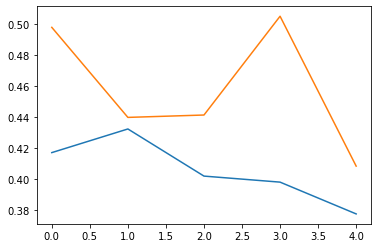

In [21]:
pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()

In [22]:
ytrain_pred = model.predict(Xtrain)
yval_pred = model.predict(Xval)

In [23]:
print(f'Training Score: {metrics.mean_absolute_error(ytrain, ytrain_pred)}')
print(f'Validation Score: {metrics.mean_absolute_error(yval, yval_pred)}')

Training Score: 0.28771952952466795
Validation Score: 0.4083515497951797


In [25]:
xtest_tfv = tfidf.transform(test_df.Review.values)
xtest_tfv = preprocesser.transform(xtest_tfv)
xtest_tfv.sort_indices()
test_df['predicted_rating'] = model.predict(xtest_tfv)

In [26]:
test_df['final_prediction'] = np.round(test_df['predicted_rating'])
test_df.loc[test_df['final_prediction']>5, 'final_prediction'] = 5
test_df.loc[test_df['final_prediction']<5, 'final_prediction'] = 1

test_df = test_df.rename({'final_prediction':'Rating'}, axis=1)

In [27]:
test_df[['Rating']].to_csv('submission.csv')

Other attempts using count vectorizer, XGBoost, etc.

In [ ]:
# ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
#                       ngram_range=(1, 3), stop_words = 'english')

# ctv.fit(train_df.Review.values)

In [ ]:
# xtrain_ctv = ctv.transform(train_df.Review.values)

In [ ]:
# xgb_model = xgb.XGBRegressor()
# xgb_model.fit(xtrain_ctv, ytrain)
# ypred_ctv = xgb_model.predict(xtrain_ctv)

In [ ]:
# print(metrics.mean_absolute_error(ytrain, ypred_ctv))

In [ ]:
# sia = SentimentIntensityAnalyzer()
# train_df['positive_score'] = train_df['Review'].apply(lambda x: sia.polarity_scores(x)['pos'])
# train_df['negative_score'] = train_df['Review'].apply(lambda x: sia.polarity_scores(x)['neg'])

In [ ]:
# train_df.pivot_table(index='Rating',
#                      values=['positive_score', 'negative_score'],
#                      aggfunc=[np.mean, np.std]).plot()

In [ ]:
# def my25(g):
#     return np.percentile(g, 25)

# def my75(g):
#     return np.percentile(g, 75)

# train_df['difference'] = train_df['positive_score'] - train_df['negative_score']

# pivot_df = train_df.pivot_table(index='Rating',
#                                 values=['difference'],
#                                 aggfunc=[np.mean, np.std, np.median, my25, my75, 'count'])

# pivot_df.columns = ['mean', 'std', 'median', 'my25', 'my75', 'count']
# pivot_df

In [ ]:
# pivot_df['95_pct_conf'] = 1.96 * pivot_df['std'] / np.sqrt(pivot_df['count'])

In [ ]:
# pivot_df['upper_level'], pivot_df['lower_level'] = pivot_df['mean'] + pivot_df['95_pct_conf'], pivot_df['mean'] - pivot_df['95_pct_conf']

In [ ]:
# pivot_df[['mean', 'upper_level', 'lower_level']].plot.bar()

In [ ]:
# train_df.boxplot(by='Rating', column='negative_score')

In [ ]:
# linear = make_pipeline(StandardScaler(), LinearRegression())
# linear.fit(train_df[['positive_score', 'negative_score']], train_df['Rating'])

In [ ]:
# test_df['positive_score'] = test_df['Review'].apply(lambda x: sia.polarity_scores(x)['pos'])
# test_df['negative_score'] = test_df['Review'].apply(lambda x: sia.polarity_scores(x)['neg'])

In [ ]:
# train_df.head()

In [ ]:
# train_df['predicted_rating'] = pd.Series(linear.predict(train_df[['positive_score', 'negative_score']]),
#                                          index=train_df.index)
# test_df['predicted_rating'] = pd.Series(linear.predict(test_df[['positive_score', 'negative_score']]),
#                                         index=test_df.index)

In [ ]:
# train_df['error'] = train_df['predicted_rating'] - train_df['Rating']

In [ ]:
# print(metrics.mean_absolute_error(train_df['Rating'], train_df['predicted_rating']))

In [ ]:
# train_df['final_prediction'] = np.round(train_df['predicted_rating'])
# train_df.loc[train_df['final_prediction']>5, 'final_prediction'] = 5
# train_df.loc[train_df['final_prediction']<5, 'final_prediction'] = 1

In [ ]:
# test_df['final_prediction'] = np.round(test_df['predicted_rating'])
# test_df.loc[test_df['final_prediction']>5, 'final_prediction'] = 5
# test_df.loc[test_df['final_prediction']<5, 'final_prediction'] = 1

In [ ]:
# test_df = test_df.rename({'final_prediction':'Rating'}, axis=1)

In [ ]:
# train_df.loc[2, 'Review']

In [ ]:
# test_df[['Rating']].to_csv('submission.csv')